In [ ]:
# Let's first load the dataset and take a look at its contents to understand its structure.
import pandas as pd

# Load the dataset
file_path = '/content/IMDB-Movie-Data - IMDB-Movie-Data.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
df.head()


,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [ ]:

# Define the rating categories based on the provided scale

def categorize_rating(rating):
    if rating >= 8:
        return 'Top Rated'
    elif 6 <= rating < 8:
        return 'Average Rated'
    else:
        return 'Low Rated'

# Apply this function to the 'Rating' column
df['Rating Category'] = df['Rating'].apply(categorize_rating)

#  extract only the relevant columns for clustering: 'Rating' and 'Votes'
df_cluster = df[['Rating', 'Votes']]

# Normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

# Converting the scaled data back into a DataFrame
df_cluster_scaled = pd.DataFrame(df_cluster_scaled, columns=['Rating', 'Votes'])


df_cluster_scaled.head()


,Rating,Votes
0,1.456999,3.112690
1,0.292924,1.674960
2,0.610399,-0.064676
3,0.504574,-0.579129
4,-0.553677,1.186839


In [ ]:
import numpy as np

# K-means implementation from scratch

def initialize_centroids(X, k):
    """ Randomly initialize centroids from the data points """
    np.random.seed(42)
    indices = np.random.choice(len(X), k, replace=False)
    return X[indices]

def assign_clusters(X, centroids):
    """ Assign each data point to the nearest centroid """
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    """ Update centroids as the mean of all points assigned to each cluster """
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

def kmeans(X, k, max_iters=100, tol=1e-4):
    """ K-means clustering algorithm """
    centroids = initialize_centroids(X, k)
    for i in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)

        # Check for convergence
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids

    return labels, centroids

# Convert the scaled DataFrame to a numpy array for K-means
X = df_cluster_scaled.values

# Define the number of clusters
k = 3

# Apply K-means clustering
labels, centroids = kmeans(X, k)

# Adding the cluster labels to the original DataFrame for analysis
df['Cluster Label'] = labels


df[['Title', 'Rating', 'Rating Category', 'Cluster Label']].head()


,Title,Rating,Rating Category,Cluster Label
0,Guardians of the Galaxy,8.1,Top Rated,1
1,Prometheus,7.0,Average Rated,1
2,Split,7.3,Average Rated,2
3,Sing,7.2,Average Rated,2
4,Suicide Squad,6.2,Average Rated,2


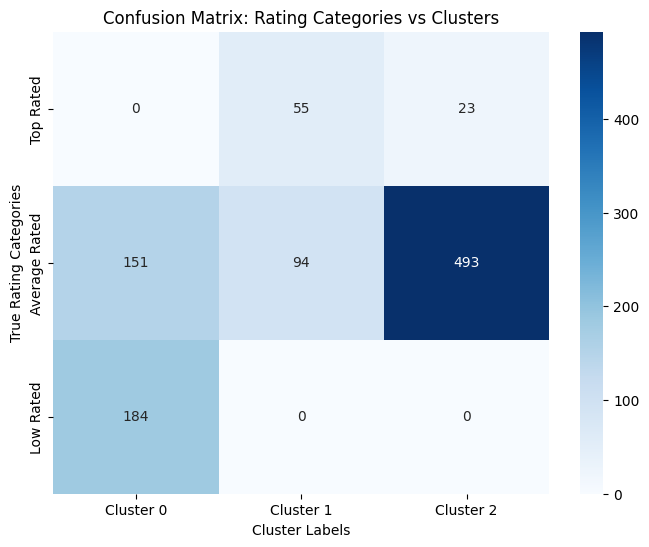

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Map the Rating Category to numerical labels for comparison with cluster labels
rating_category_to_label = {'Top Rated': 0, 'Average Rated': 1, 'Low Rated': 2}
df['Rating Category Label'] = df['Rating Category'].map(rating_category_to_label)

# Generate the confusion matrix
conf_matrix = confusion_matrix(df['Rating Category Label'], df['Cluster Label'])

# Plot the confusion matrix for visual interpretation
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1', 'Cluster 2'],
            yticklabels=['Top Rated', 'Average Rated', 'Low Rated'])
plt.title('Confusion Matrix: Rating Categories vs Clusters')
plt.xlabel('Cluster Labels')
plt.ylabel('True Rating Categories')
plt.show()


In [ ]:
# Split the genres into lists for each movie
df['Genre List'] = df['Genre'].apply(lambda x: x.split(','))

# Group the movies by their assigned clusters and analyze the genres within each cluster
cluster_genres = df.groupby('Cluster Label')['Genre List'].apply(lambda genres: [g for sublist in genres for g in sublist])

# Count the genre occurrences in each cluster
cluster_genre_counts = cluster_genres.apply(lambda genres: pd.Series(genres).value_counts())

# Display the genre distribution for each cluster
cluster_genre_counts


,Drama,Action,Comedy,Adventure,Thriller,Horror,Romance,Crime,Fantasy,Sci-Fi,Mystery,Family,Animation,Biography,History,Music,Sport,War,Western,Musical
Cluster Label,,,,,,,,,,,,,,,,,,,,
0,132.0,110.0,106.0,81.0,72.0,69.0,51.0,44.0,41.0,38.0,28.0,19.0,6.0,5.0,5.0,4.0,2.0,2.0,2.0,1.0
1,65.0,64.0,30.0,73.0,25.0,4.0,10.0,20.0,22.0,37.0,18.0,5.0,12.0,14.0,5.0,1.0,1.0,4.0,1.0,NaN
2,316.0,129.0,143.0,105.0,98.0,46.0,80.0,86.0,38.0,45.0,60.0,27.0,31.0,62.0,19.0,11.0,15.0,7.0,4.0,4.0


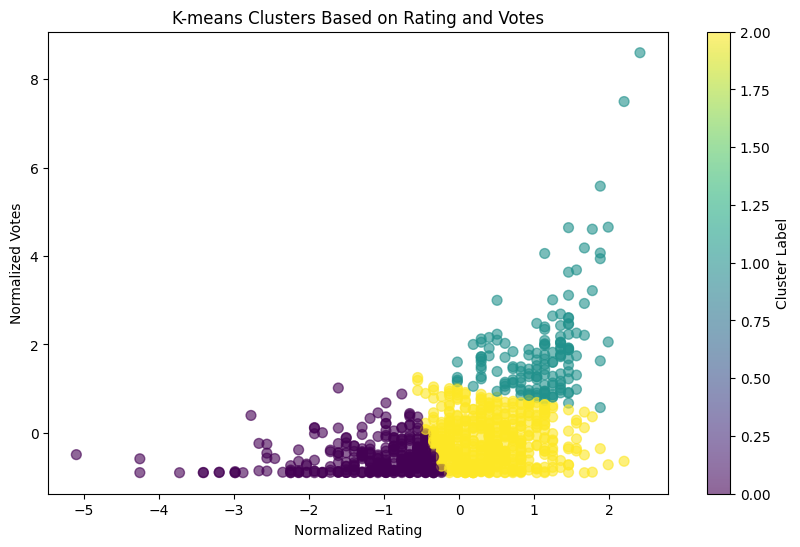

In [ ]:
# Visualizing the clusters based on Rating and Votes
plt.figure(figsize=(10, 6))

# Plot the clusters
plt.scatter(df_cluster_scaled['Rating'], df_cluster_scaled['Votes'], c=labels, cmap='viridis', s=50, alpha=0.6)
plt.title('K-means Clusters Based on Rating and Votes')
plt.xlabel('Normalized Rating')
plt.ylabel('Normalized Votes')
plt.colorbar(label='Cluster Label')
plt.show()
